In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
from scipy import stats, sparse
from scipy.stats import nbinom
from scipy.special import beta as BF
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
from scipy.optimize import fsolve

## Load Data

6 cell types
14 regions


<Figure size 432x288 with 0 Axes>

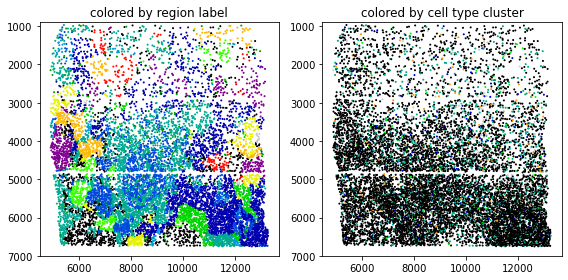

In [3]:
dataset_ID = 'E2' #C1, D1, E2
dataset_path = '../data/CN21_' + dataset_ID + '_cell_types.tsv'
df = pd.read_csv(dataset_path)
#df.head()
cell_type_names = df['cell_type'].unique()
n_cell_types = len(cell_type_names)
cell_type_name_id_dict = dict(zip(cell_type_names, np.arange(0, n_cell_types).astype(int)))
reg_names = df['poly.ID'].unique()
n_regions = len(reg_names)
reg_name_id_dict = dict(zip(reg_names, np.arange(0, n_regions)))
print("%s cell types" % n_cell_types)
print("%s regions" % n_regions)
cmap = cm.get_cmap('nipy_spectral', n_cell_types)

color_list = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    #print(colors.rgb2hex(rgb))
    color_list.append(colors.rgb2hex(rgb))

type_color_dict = dict(zip(cell_type_names, color_list))


cmap = cm.get_cmap('nipy_spectral', n_regions)

color_list = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    #print(colors.rgb2hex(rgb))
    color_list.append(colors.rgb2hex(rgb))

reg_color_dict = dict(zip(reg_names, color_list))

df['cell_type_id'] = df['cell_type'].apply(lambda x: cell_type_name_id_dict[x])
df['region_id'] = df['poly.ID'].apply(lambda x: reg_name_id_dict[x])
df['cell_type_color'] = df['cell_type'].apply(lambda x: type_color_dict[x])
df['reg_color'] = df['poly.ID'].apply(lambda x: reg_color_dict[x])

plt.clf()
fix, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
ax1.scatter(df['segment_px_x'], df['segment_px_y'], color=df['reg_color'], marker='o', s=1)
ax1.set_title('colored by region label')
ax1.set_ylim(7000,900)
ax2.scatter(df['segment_px_x'], df['segment_px_y'], color=df['cell_type_color'], marker='o', s=1)
ax2.set_title('colored by cell type cluster')
ax2.set_ylim(7000,900)
#plt.gca().invert_yaxis()
plt.savefig('../fig/full_data_region_type_sidebyside.pdf')
plt.tight_layout()
plt.show()

## Load IST

In [4]:
B_composite = np.load('../data/tiles/B_composite.npy')
C_composite_trim = np.load('../data/tiles/C_composite_trim.npy')
A_composite = sparse.load_npz('../data/tiles/A_composite.npz')

In [5]:
type_dict = dict()
for i in range(0, B_composite.shape[0]):

    for j in range(0, B_composite.shape[1]):
        if B_composite[i, j] == 1:
            type_dict[i] = j
            
position_dict = dict()
for i in range(0, C_composite_trim.shape[0]):
    position_dict[i] = C_composite_trim[i, :]
    
point_list = [position_dict[i] for i in range(0, C_composite_trim.shape[0])]
colors = [type_color_dict[cell_type_names[type_dict[i]]] for i in range(0, B_composite.shape[0])]

types = np.array(list(type_dict.values())).astype(int)
arr = np.vstack(([i for i in range(0, B_composite.shape[0])], C_composite_trim[:,0], C_composite_trim[:,1], types)).T
df_ist = pd.DataFrame(arr, columns = ['cellID', 'segment_px_x', 'segment_px_y', 'cell_type_id'])
df_ist['cell_type_color'] = np.array(colors)

<Figure size 432x288 with 0 Axes>

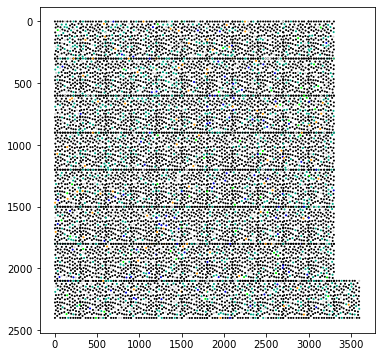

In [5]:
plt.clf()
fig, ax2 = plt.subplots(1,1,figsize=(6,6))
plt.scatter(np.array(point_list)[:,0], np.array(point_list)[:,1], c=colors, s=1)
#plt.hlines(y_bounds,min(x_bounds), max(x_bounds))
#plt.vlines(x_bounds,min(y_bounds), max(y_bounds))
#ax2.set(xlim=(0 - 0.01*ab[0], ab[0] + 0.01 * ab[0]), ylim=(7100, 0 - 0.01*ab[1]/2))
#plt.savefig('../fig/full_osmfish_brain_400px_300tiles_28cells.png', dpi=400)
plt.gca().invert_yaxis()
plt.show()

In [6]:
df.head()

,bc,segment_id,segment_px_x,segment_px_y,cell_type,poly.ID,cell_type_id,region_id,cell_type_color,reg_color
1,1000x17,7622,9286.251723,1112.430409,epithelial,Fatty tissue,0,0,#000000,#000000
2,1000x175,16386,9287.929553,2254.195876,endothelial,Fatty tissue;Fibrous tissue;Invasive cancer;im...,1,1,#0000dd,#800091
3,1000x254,21270,9262.589988,2831.436234,epithelial,Fibrous tissue;Invasive cancer;immune/lymphoid,0,2,#000000,#0000ae
4,1000x287,23836,9273.606853,3098.420198,stroma,Fibrous tissue;Invasive cancer;immune/lymphoid,2,2,#00aa88,#0000ae
5,1000x313,25182,9278.407143,3253.669481,epithelial,Invasive cancer,0,3,#000000,#0049dd


<Figure size 432x288 with 0 Axes>

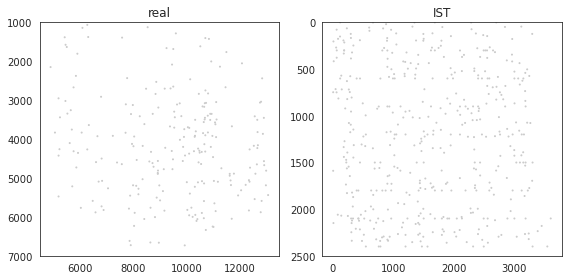

In [12]:
toi = 5

def plot_toi(df, df_ist, toi, outdir=None, filename=None):
    
    df_toi = df[df['cell_type_id'] == toi]
    df_ist_toi = df_ist[df_ist['cell_type_id'] == toi]
    
    plt.clf()
    sns.set_style('white')
    fix, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
    ax1.scatter(df_toi['segment_px_x'], df_toi['segment_px_y'], color=df_toi['cell_type_color'], marker='o', s=1)
    ax1.set_title('real')
    ax1.set_ylim(7000,1000)
    
    
    ax2.scatter(df_ist_toi['segment_px_x'], df_ist_toi['segment_px_y'], color=df_ist_toi['cell_type_color'], marker='o', s=1)
    ax2.set_title('IST')
    ax2.set_ylim(2500,0)
    #ax2.set_xlim(0,4000)
    #plt.gca().invert_yaxis()
    #plt.savefig('../fig/full_osmFISH_data_real_IST_sidebyside.pdf')
    plt.tight_layout()
    
    
    if outdir != None:
        plt.savefig(outdir + filename)
    plt.show()
plot_toi(df, df_ist, toi, outdir='../fig/', filename='real_ist_sidebyside_type' + str(toi) + '.pdf')

<Figure size 432x288 with 0 Axes>

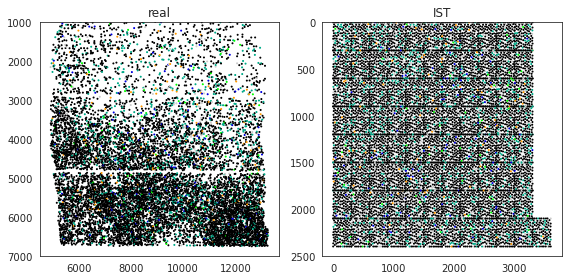

In [6]:
df_toi = df.sort_values('')
df_ist_toi = df_ist

plt.clf()
sns.set_style('white')
fix, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
ax1.scatter(df_toi['segment_px_x'], df_toi['segment_px_y'], color=df_toi['cell_type_color'], marker='o', s=1)
ax1.set_title('real')
ax1.set_ylim(7000,1000)


ax2.scatter(df_ist_toi['segment_px_x'], df_ist_toi['segment_px_y'], color=df_ist_toi['cell_type_color'], marker='o', s=1)
ax2.set_title('IST')
ax2.set_ylim(2500,0)
#ax2.set_xlim(0,4000)
#plt.gca().invert_yaxis()
#plt.savefig('../fig/full_osmFISH_data_real_IST_sidebyside.pdf')
plt.tight_layout()

## Sampling experiments

### Helper functions

In [11]:
def build_assignment_matrix(attribute_dict, n_cell_types):
    data = list(attribute_dict.items())
    data = np.array(data)  # Assignment matrix

    B = np.zeros((data.shape[0], n_cell_types))  # Empty matrix

    for i in range(0, data.shape[0]):
        t = int(data[i, 1])
        B[i, t] = 1

    return B

def calculate_FOV_size(sampling_frac, min_x, max_x, min_y, max_y):
    area = (max_x - min_x) * (max_y - min_y)
    sampling_area = sampling_frac * area
    FOV_dim = np.round(np.sqrt(sampling_area))
    return FOV_dim

def random_FOV(FOV_dim, df, min_x, max_x, min_y, max_y):
    x_start = np.random.randint(min_x, max_x - FOV_dim)
    y_start = np.random.randint(min_y, max_y - FOV_dim)
    
    x_filtered = df[(df['segment_px_x'] > x_start) & (df['segment_px_x'] < x_start + FOV_dim)]
    random_FOV = x_filtered[(x_filtered['segment_px_y'] > y_start) & (x_filtered['segment_px_y'] < y_start + FOV_dim)]
    
    return random_FOV

def calculate_p_in_fov(fov, n_cell_types):
    types_in_fov = fov['cell_type_id'].tolist()
    #print(types_in_fov)
    attribute_dict = dict(zip(fov.index, types_in_fov))
    B = build_assignment_matrix(attribute_dict, n_cell_types)
    return np.divide(np.sum(B, axis=0), B.shape[0])

def estimate_beta_from_FOV(df, fov_dim, type_of_interest, n_fov, x_min, x_max, y_min, y_max, n_cell_types):
    p_list = []
    i = 0
    ns = []
    while i < n_fov:
        fov = random_FOV(fov_dim, df, x_min, x_max, y_min, y_max)
        if len(fov) > 10:
            # because we don't define the boundary of the TISSUE just the boundary of the image
            # you could draw an fov out of tissue bounds but in the enclosing rectangle
            p_list.append(calculate_p_in_fov(fov, n_cell_types))
            ns.append(len(fov))
            i += 1
        else:
            continue
    print(ns)
    sample_proportions = np.vstack(p_list)
    props_of_interest = sample_proportions[:, type_of_interest]
    
    sample_mean = np.mean(props_of_interest)
    sample_var = np.var(props_of_interest)
    
    #print()
    alpha_hat = sample_mean * (((sample_mean*(1-sample_mean))/sample_var) - 1)
    beta_hat = (1 - sample_mean) * (((sample_mean*(1-sample_mean))/sample_var) - 1)
    
    #print(sample_mean, sample_var)
    #print(alpha_hat, beta_hat)
    return alpha_hat, beta_hat, props_of_interest, ns

def estimate_beta_from_FOV(df, fov_dim, type_of_interest, n_fov, x_min, x_max, y_min, y_max, n_cell_types):
    p_list = []
    i = 0
    ns = []
    while i < n_fov:
        fov = random_FOV(fov_dim, df, x_min, x_max, y_min, y_max)
        if len(fov) > 10:
            # because we don't define the boundary of the TISSUE just the boundary of the image
            # you could draw an fov out of tissue bounds but in the enclosing rectangle
            p_list.append(calculate_p_in_fov(fov, n_cell_types))
            ns.append(len(fov))
            i += 1
        else:
            continue
    print(ns)
    sample_proportions = np.vstack(p_list)
    props_of_interest = sample_proportions[:, type_of_interest]
    
    sample_mean = np.mean(props_of_interest)
    sample_var = np.var(props_of_interest)
    
    #print()
    alpha_hat = sample_mean * (((sample_mean*(1-sample_mean))/sample_var) - 1)
    beta_hat = (1 - sample_mean) * (((sample_mean*(1-sample_mean))/sample_var) - 1)

    return alpha_hat, beta_hat, props_of_interest, ns

def estimate_beta_from_FOV_ds(df, fov_dim, type_of_interest, n_fov, x_min, x_max, y_min, y_max, 
                           n_cell_types, target_size):
    p_list = []
    i = 0
    ns = []
    while i < n_fov:
        fov = random_FOV(fov_dim, df, x_min, x_max, y_min, y_max)
        if len(fov) == target_size:
            # because we don't define the boundary of the TISSUE just the boundary of the image
            # you could draw an fov out of tissue bounds but in the enclosing rectangle
            p_list.append(calculate_p_in_fov(fov, n_cell_types))
            ns.append(len(fov))
            i += 1
        elif len(fov) > target_size:
            #n_to_remove = len(fov) - target_size
            fov = fov.sample(n=target_size, replace=False)
            p_list.append(calculate_p_in_fov(fov, n_cell_types))
            ns.append(len(fov))
            i += 1
        else:
            continue
    #print(ns)
    sample_proportions = np.vstack(p_list)
    props_of_interest = sample_proportions[:, type_of_interest]
    
    sample_mean = np.mean(props_of_interest)
    sample_var = np.var(props_of_interest)
    
    #print()
    alpha_hat = sample_mean * (((sample_mean*(1-sample_mean))/sample_var) - 1)
    beta_hat = (1 - sample_mean) * (((sample_mean*(1-sample_mean))/sample_var) - 1)

    return alpha_hat, beta_hat, props_of_interest

def p_fov_with_rarest(a, b, m, N):
    return 1 - np.power((BF(a, b + m)/BF(a, b)), N)

def fov_cell_counts(df, fov_dim, toi, n_fov, x_min, x_max, y_min, y_max, n_cell_types, ret_n = False):
    
    p_list = []
    i = 0
    ns = []
    while i < n_fov:
        fov = random_FOV(fov_dim, df, x_min, x_max, y_min, y_max)
        if len(fov) > 10:
            types_in_fov = fov['cell_type_id'].astype(int).tolist()
            #print(types_in_fov)
            attribute_dict = dict(zip(fov.index, types_in_fov))
            B = build_assignment_matrix(attribute_dict, n_cell_types)
            p_list.append(np.sum(B, axis=0))
            ns.append(len(fov))
            i += 1
        else:
            continue
        
    sample_counts = np.vstack(p_list)
    
    if ret_n == True:
        return sample_counts[:, toi].astype(int), np.sum(sample_counts, axis=1).astype(int)
    else:
        return sample_counts[:, toi].astype(int)
    
def convert_params(m, k):
    """ 
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    Parameters
    ----------
    m : float 
       Mean
    k : float
       Overdispersion parameter. 
    """
    k = 1/k
    var = m + k * m ** 2
    p = (var - m) / var
    r = m ** 2 / (var - m)
    return r, 1-p

In [8]:
x_min = min(df['segment_px_x'])
x_max = max(df['segment_px_x'])
y_min = min(df['segment_px_y'])
y_max = max(df['segment_px_y'])

fov_size_05r = calculate_FOV_size(0.005, x_min, x_max, y_min, y_max)
fov_size_1r = calculate_FOV_size(0.01, x_min, x_max, y_min, y_max)
fov_size_5r = calculate_FOV_size(0.05, x_min, x_max, y_min, y_max)
fov_size_75r = calculate_FOV_size(0.075, x_min, x_max, y_min, y_max)
fov_size_10r = calculate_FOV_size(0.10, x_min, x_max, y_min, y_max)

x_min = min(df_ist['segment_px_x'])
x_max = max(df_ist['segment_px_x'])
y_min = min(df_ist['segment_px_y'])
y_max = max(df_ist['segment_px_y'])

fov_size_05i = calculate_FOV_size(0.005, x_min, x_max, y_min, y_max)
fov_size_1i = calculate_FOV_size(0.01, x_min, x_max, y_min, y_max)
fov_size_5i = calculate_FOV_size(0.05, x_min, x_max, y_min, y_max)
fov_size_75i = calculate_FOV_size(0.075, x_min, x_max, y_min, y_max)
fov_size_10i = calculate_FOV_size(0.10, x_min, x_max, y_min, y_max)

In [12]:
toi = 3 #type of interest
n_fov = 1000 #number of FOVs from which parameters are estimated.

x_min = min(df['segment_px_x'])
x_max = max(df['segment_px_x'])
y_min = min(df['segment_px_y'])
y_max = max(df['segment_px_y'])

n_toi_observed, ns= fov_cell_counts(df, fov_size_5r, toi, n_fov, x_min, x_max, y_min, y_max, n_cell_types, ret_n=True )

values, counts = np.unique(n_toi_observed, return_counts=True)

In [13]:
np.mean(ns)

491.329

Text(0, 0.5, 'Count')

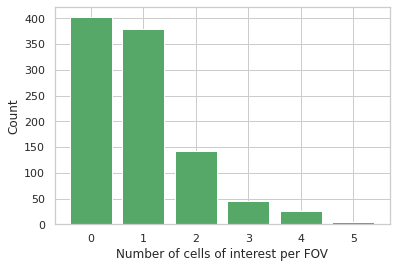

In [78]:
v = np.arange(0, max(values) + 1)
val_count = dict(zip(values, counts))
c = [val_count[i] if i in values else 0 for i in v]
plt.bar(v, c, color='g')
_ = plt.xticks(ticks=v)
plt.xlabel('Number of cells of interest per FOV')
plt.ylabel('Count')

### Estimate NB Parameters

#### method of moments

Text(0, 0.5, 'Count')

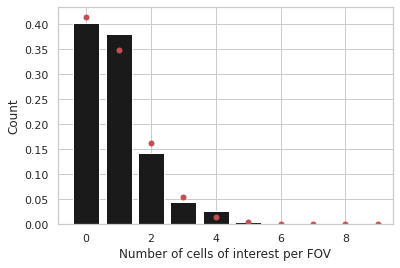

In [79]:
xbar = np.mean(n_toi_observed)
x2bar = np.mean(n_toi_observed**2)

k = xbar**2/(x2bar - xbar**2 - xbar)
m = xbar

r, p = convert_params(m, k)

v = np.arange(0, max(values) + 1)
val_count = dict(zip(values, counts))
c = np.array([val_count[i] if i in values else 0 for i in v])
plt.bar(v, c/n_fov, color='k')
x = np.arange(nbinom.ppf(1e-5, r, p),
              nbinom.ppf(1-1e-6, r, p))
plt.plot(x, nbinom.pmf(x, r, p), 'ro', ms=5, label='nbinom pmf')

#_ = plt.xticks(ticks=v)
plt.xlabel('Number of cells of interest per FOV')
plt.ylabel('Count')

#### ZTM

In [80]:
v = np.arange(0, max(values) + 1)
val_count = dict(zip(values, counts))
c = np.array([val_count[i] if i in values else 0 for i in v])

n0 = c[0]
N = np.sum(c)
p0 = n0/N
m = np.mean(n_toi_observed)

def f2(k, p0, m):
    return np.power((m/k + 1), -k) - p0

k = fsolve(f2, x0=0.2, args=(p0, m))

r, p = convert_params(m, k[0])

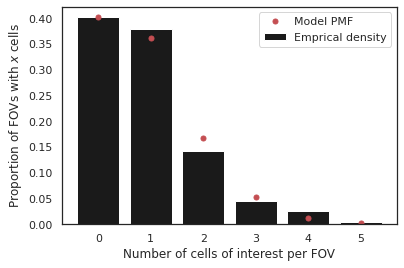

In [81]:
sns.set_style('white')
plt.bar(v, c/n_fov, color='k', label = 'Emprical density')
x = np.arange(nbinom.ppf(1e-5, r, p),
              nbinom.ppf(1-1e-4, r, p))
plt.plot(x, nbinom.pmf(x, r, p), 'ro', ms=5, label='Model PMF')

#_ = plt.xticks(ticks=v)
plt.xlabel('Number of cells of interest per FOV')
plt.ylabel('Proportion of FOVs with $x$ cells')
plt.legend()
plt.savefig('../fig/empirical_hist_with_model_type' + str(toi) + 'pdf')

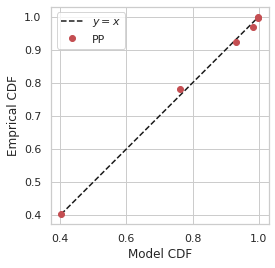

In [82]:
c_normed = c/n_fov
ecdf = np.cumsum(c_normed)
model_pmf = nbinom.pmf(x, r, p)
model_cdf = np.cumsum(model_pmf[:len(ecdf)])

xx = np.linspace(min(min(model_cdf), min(ecdf)),1)
sns.set(style='whitegrid')
plt.plot(xx, xx, 'k--', label = '$y=x$')
plt.plot(model_cdf, ecdf, 'ro', label='PP')
plt.xlabel('Model CDF')
plt.ylabel('Emprical CDF')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(frameon=True)
#plt.tight_layout()
plt.savefig('../fig/emp_model_PP_type' + str(toi) + 'pdf')

### Construct FOV plots

In [43]:
def do_model_trials(df, fov_size, toi, n_cell_types, n_fov, n_trials):
    
    x_min = min(df['segment_px_x'])
    x_max = max(df['segment_px_x'])
    y_min = min(df['segment_px_y'])
    y_max = max(df['segment_px_y'])

    trial_counter = 0
    
    def f2(k, p0, m):
            return np.power((m/k + 1), -k) - p0
        
    ns = np.arange(0,10)
    while trial_counter < n_trials:
        n_toi_observed = fov_cell_counts(df, fov_size, toi, n_fov, x_min, x_max, y_min, y_max, n_cell_types)
        values, counts = np.unique(n_toi_observed, return_counts=True)
        v = np.arange(0, max(values) + 1)
        val_count = dict(zip(values, counts))
        c = np.array([val_count[i] if i in values else 0 for i in v])
        
        #Parameter estimation with ZTM method
        n0 = c[0]
        N = np.sum(c)
        p0 = n0/N
        m = np.mean(n_toi_observed)
        k = fsolve(f2, x0=0.2, args=(p0, m))
        r, p = convert_params(m, k[0])
        
        x = np.arange(0, 60)
        if trial_counter == 0:
            res = nbinom.pmf(x, r, p)
            fov = p_discovery_in_n_fov(p0, ns)
        else:
            res = np.vstack((res, nbinom.pmf(x, r, p)))
            fov = np.vstack((fov, p_discovery_in_n_fov(p0, ns)))
        trial_counter += 1 
    
    return res, fov

def p_discovery_in_n_fov(p0, n):
        return 1 - np.power(p0, n)

In [101]:
toi = 1
n_fov = 30 #for estimating the parameters
n_trials = 50 #for CI

res_1r, fov_1r = do_model_trials(df, fov_size=fov_size_1r, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials)
res_5r, fov_5r = do_model_trials(df, fov_size=fov_size_5r, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials)
res_10r, fov_10r = do_model_trials(df, fov_size=fov_size_10r, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials)
res_05r, fov_05r = do_model_trials(df, fov_size=fov_size_05r, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials)

res_1i, fov_1i = do_model_trials(df_ist, fov_size=fov_size_1i, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials)
res_5i, fov_5i = do_model_trials(df_ist, fov_size=fov_size_5i, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials)
res_10i, fov_10i = do_model_trials(df_ist, fov_size=fov_size_10i, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials)
res_05i, fov_05i = do_model_trials(df_ist, fov_size=fov_size_05i, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials)

/broad/software/free/Linux/redhat_7_x86_64/pkgs/anaconda3_2020.07/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [102]:
def calc_errs(arr, ci=0.95):
    means = np.mean(arr, axis = 0)
    std = np.std(arr, axis = 0)
    ci = stats.norm.ppf(0.95) * (std/np.sqrt(arr.shape[0]))
    return means, ci

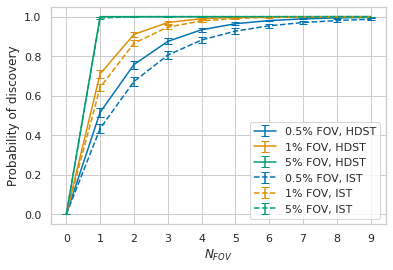

In [103]:
labels = ['0.5% FOV, HDST', '1% FOV, HDST', '5% FOV, HDST', '10% FOV, HDST',
          '0.5% FOV, IST', '1% FOV, IST', '5% FOV, IST', '10% FOV, IST']
arrs = [fov_05r, fov_1r, fov_5r, fov_10r, fov_05i, fov_1i, fov_5i, fov_10i]
ns = np.arange(0,10)
sns.set_style('whitegrid')
for i in range(0, len(arrs)):
    mean, ci = calc_errs(arrs[i], ci=0.95)
    if i == 3 or i == 7:
        continue
    elif i < 4:
        plt.errorbar(ns, mean, yerr=ci, label=labels[i], color = sns.color_palette('colorblind')[i%4], capsize=4)
    else:
        plt.errorbar(ns, mean, yerr=ci, label=labels[i], linestyle='dashed', capsize=4, color = sns.color_palette('colorblind')[i%4])
        
    _ = plt.xticks(ticks=ns)
    plt.xlabel('$N_{FOV}$')
    plt.ylabel('Probability of discovery')
    plt.legend()
    #plt.tight_layout()
    plt.savefig('../fig/nFOVs_cell'+str(toi)+'discovery_ci95_HDST_E2.pdf')